## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

Remember to bandpass filter all your signals. Use the 40-240BPM range to create your pass band.
Use plt.specgram to visualize your signals in the frequency domain. You can plot your estimates on top of the spectrogram to see where things are going wrong.
When the dominant accelerometer frequency is the same as the PPG, try picking the next strongest PPG frequency if there is another good candidate.
Sometimes the cadence of the arm swing is the same as the heartbeat. So if you can't find another good candidate pulse rate outside of the accelerometer peak, it may be the same as the accelerometer.
One option for a confidence algorithm is to answer the question, "How much energy in the frequency spectrum is concentrated near the pulse rate estimate?" You can answer this by summing the frequency spectrum near the pulse rate estimate and dividing it by the sum of the entire spectrum.

To do this instead of taking the strongest frequency of the ppg as your estimate, try to take the N st
rongest frequencies and select the one that is closest to your previous estimate.

### Code

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io
from matplotlib import pyplot as plt
import scipy.signal

fs=125
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)
    print(pr_errors.shape)
    print(confidence_est.shape)
    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    print(np.array(confs).shape)
    errs = np.hstack(errs)
    confs = np.hstack(confs)
#     print(confs.shape)
    return AggregateErrorMetric(errs, confs)

    
def BandpassFilter(signal, fs):
    b, a = scipy.signal.butter(3, [40/60, 240/60], btype='bandpass', fs=fs)
    return scipy.signal.filtfilt(b, a, signal)
def FourierTransform(sig, fs):
    freqs = np.fft.rfftfreq(len(sig), 1/fs)
    fft = np.abs(np.fft.rfft(sig))
    fft[freqs <= 40/60.0] = 0.0
    fft[freqs >= 240/60.0] = 0.0
    return freqs, fft

def Featurize(ppg, accx, accy, accz):
    """ Create features """
    fs = 125
    ppg = BandpassFilter(ppg,fs)
    accx = BandpassFilter(accx,fs)
    accy = BandpassFilter(accy,fs)
    accz = BandpassFilter(accz,fs)

    # Fourier Transform and the frequency domain
    freqs, fft = FourierTransform(ppg, fs)
    freqs_accx, accx_fft = FourierTransform(accx, fs)
    freqs_accy, accy_fft = FourierTransform(accy, fs)
    freqs_accz, accz_fft = FourierTransform(accz, fs)

    max_freq_ppg = freqs[np.argsort(np.abs(fft))]
    
#     take the top three components from each accelerometer signal
    max_freq_accx = freqs_accx[np.argsort(np.abs(accx_fft))][-4:-1]
    max_freq_accy = freqs_accy[np.argsort(np.abs(accy_fft))][-4:-1]
    max_freq_accz = freqs_accz[np.argsort(np.abs(accz_fft))][-4:-1]

    for i in range(1,len(max_freq_ppg)):
        if np.all(abs(max_freq_accx - max_freq_ppg[-i])>0.15) &\
        np.all(abs(max_freq_accy - max_freq_ppg[-i])>0.15) &\
        np.all(abs(max_freq_accz - max_freq_ppg[-i])>0.15):
            ppg_feature = max_freq_ppg[-i]
            break

    return ppg_feature

def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ground= np.array(sp.io.loadmat(ref_fl)['BPM0'])
#     ground = ground.reshape(len(ground))

#   first filter the signals
    ppg = BandpassFilter(ppg,fs)
    accx = BandpassFilter(accx,fs)
    accy = BandpassFilter(accy,fs)
    accz = BandpassFilter(accz,fs)
    
    # Grab features from each window
    window_length_s = 8
    window_shift_s = 8
    window_length = window_length_s * fs
    window_shift = window_shift_s * fs
    est_freq =  []
    confidence = []
    
    for i in range(0, len(ppg) - window_length, window_shift):
        
        ppg_w = ppg[i:i + window_length]
        accx_w = accx[i:i + window_length]
        accy_w = accy[i:i + window_length]
        accz_w = accz[i:i + window_length]
        
        est_freq.append(Featurize(ppg_w, accx_w, accy_w, accz_w))
    
    for i in range(len(est_freq)):
        snr = CalcSNR(ppg, est_freq[i])
        confidence.append(snr)
    
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors=[]
    est_bpm = est_freq * 60  # convert to heart rate  
    error = np.abs((est_bpm - ground[0]))
#     print(error)
#     print(np.array(error).shape)
    errors.append(error)
#     print(np.array(confidence).shape)
    return (np.array(errors), np.array(confidence))


def CalcSNR(sig, hr_bpm):
    fs = 125

    hr_f = hr_bpm/60
    harmonic_f = hr_f*2

    freqs = np.fft.rfftfreq(len(sig), 1/fs)
    fft_mag = np.abs(np.fft.rfft(sig))

    window_f = 5/60 
    fundamental_freq_window = (freqs>hr_f-window_f) & (freqs< hr_f + window_f)
    harmonic_freq_window = (freqs>harmonic_f-window_f) & (freqs< harmonic_f + window_f)

    # Compute signal power and noise power
    signal_power = np.sum(fft_mag[(fundamental_freq_window)| (harmonic_freq_window)])
    
#     print(fft_mag[(fundamental_freq_window)| (harmonic_freq_window)])
    noise_power =  np.sum(~(fft_mag[(fundamental_freq_window)| (harmonic_freq_window)]).astype(int))

    # Compute SNR
    snr = signal_power / noise_power
    return snr

In [2]:
Evaluate()

(12,)
(1, 26100)
(435,)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 435


IndexError: index 1 is out of bounds for axis 0 with size 1

In [5]:
fs = 125
data_fls, ref_fls = LoadTroikaDataset()

In [8]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

In [60]:
ground_truth = np.array(sp.io.loadmat(ref_fls[0])['BPM0'])

In [62]:
fft_len = max(len(ground_truth), 2046)# Create an array of frequency bins
freqs_ground = np.fft.rfftfreq(fft_len, 1 / fs)
fft_ground = np.fft.rfft(ground_truth - np.mean(ground_truth), fft_len)

In [10]:
fft_len = max(len(accx), 2046)# Create an array of frequency bins
freqs = np.fft.rfftfreq(fft_len, 1 / fs)
fft_x = np.fft.rfft(accx - np.mean(accx), fft_len)


In [ ]:
freqs = np.fft.rfftfreq(len(ppg), 1/fs)
fft_mag = np.abs(np.fft.rfft(ppg))

In [29]:
np.abs(fft_x)[low_freqs]

array([  1.42579074e+03,   6.39596107e+02,   1.50974718e+03, ...,
         4.12338605e-02,   3.38603085e-02,   1.25845933e-02])

In [92]:
freqs[np.argmax(np.abs(fft))]

3.9308590558030421

In [36]:
freqs[np.argsort(np.abs(fft_ppg))][-4:-1]


array([ 1.46954161,  2.96214777,  2.91272373])

(0, 30)

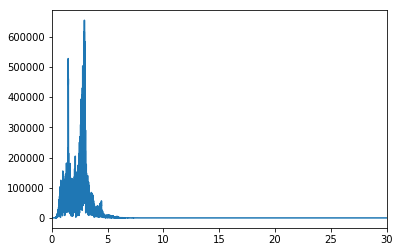

In [49]:
pks = sp.signal.find_peaks(abs(fft_ppg), height=2000)[0]
plt.plot(freqs,abs(fft_ppg))
plt.plot(pks, abs(fft_ppg)[pks], 'r.', ms=10)
plt.xlim((0,30))

## Data exploration

In [10]:
for idx, file in enumerate(data_fls):
    ppg, accx, accy, accz = LoadTroikaDataFile(file)

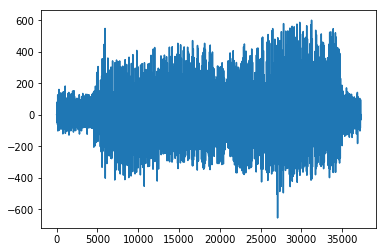

In [49]:
plt.plot(ppg)


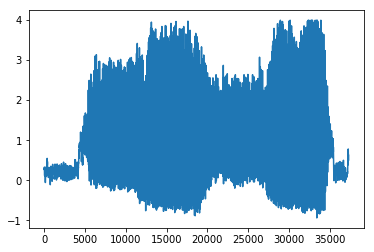

In [18]:
plt.plot(accy)


(0, 8)

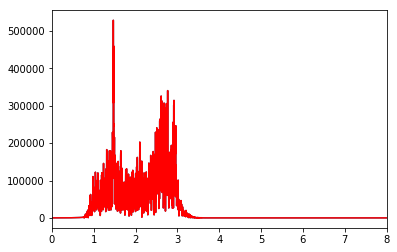

In [99]:
freqs = np.fft.rfftfreq(len(ppg), 1/fs)
fft_mag = np.abs(np.fft.rfft(ppg))
plt.plot(freqs, fft_mag)
plt.plot(freqs, abs(fft_mag),'r')
plt.xlim((0,8))

(0, 8)

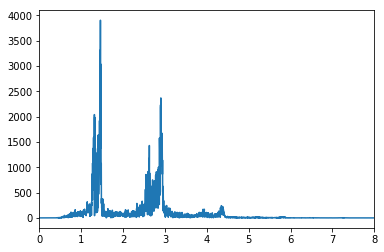

In [46]:
freqs_acc = np.fft.rfftfreq(len(accz), 1/fs)
fft_mag_acc = np.abs(np.fft.rfft(accz))
plt.plot(freqs_acc, fft_mag_acc)
plt.xlim((0,8))

(0, 15)

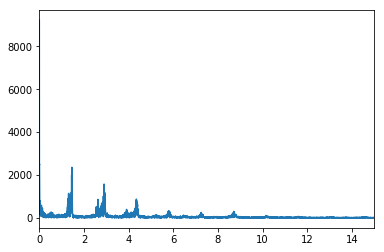

In [30]:
freqs = np.fft.rfftfreq(len(accx), 1/fs)
fft_mag = np.abs(np.fft.rfft(accx))
plt.plot(freqs, fft_mag)
plt.xlim((0,15))

(0, 7)

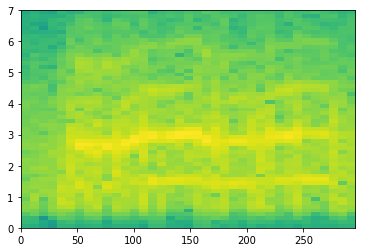

In [57]:
plt.figure()
spec, freqs, _,_ = plt.specgram(accy, NFFT=fs*8, Fs = fs, noverlap=0)
plt.ylim((0,7))

(0, 7)

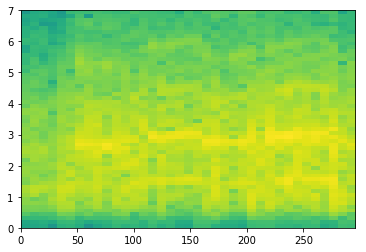

In [56]:
ppg_spec, ppg_freqs, t1, _ = plt.specgram(ppg, NFFT= 8*fs, Fs=fs, noverlap= 0)
plt.ylim((0,7))

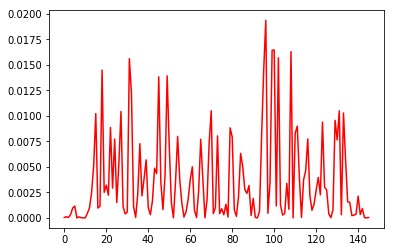

In [54]:
plt.plot(ppg_spec[0],'r')

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

### Code description

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 